In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy import stats

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio

# spatial statistics
from esda.moran import Moran
from esda.getisord import G_Local
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# data source:
file_path1 = '/content/drive/My Drive/X999/bbl_evictions_merged_covid.csv'
file_path3 = '/content/drive/My Drive/X999/bbl_cleaned.csv'
# file_path2 = '/content/drive/My Drive/X999/evictions_pre_post_covid.csv'

In [11]:
# evictions= pd.read_csv(file_path2)
bbl_cleaned= pd.read_csv(file_path3)

In [12]:
# list(bbl_cleaned.columns),
bbl_cleaned.shape
# so 753110 res buildings
# will use this number to calculate the average number of evictions per building, but not only the builingds that
# have the evictions, but all the res buildings

(753110, 112)

In [8]:
# evictions.eviction_count.sum()

In [13]:
bbl_evictions_merged_raw = pd.read_csv(file_path1)

In [14]:
bbl_evictions_merged = bbl_evictions_merged_raw.copy()

In [15]:
display(bbl_evictions_merged.head()), bbl_evictions_merged.shape

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,...,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade
0,35484/19,494073,184 MT. EDEN PARKWAY,UNIT 1D,2020-01-02,BRONX,10457,Not an Ejectment,Possession,40.842943,...,False,mid-rise,"Pre-1947, pre-rent-control","1921–1930, Art Deco Skyscrapers","Pre-1929, pre-great depression",21-100 units,True,large,Q4 (largest 25%),1920-1929
1,251388/19,117473,160 EAST 117 STREET,3-B,2020-01-02,MANHATTAN,10035,Not an Ejectment,Possession,40.799094,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,66822/19,25733,66-07 ALDERTON ST,unknown,2020-01-02,QUEENS,11374,Not an Ejectment,Possession,40.719316,...,False,low-rise,"1994–Present, vacancy decontrol","1981–2000, Post-Modernism","1991–2008, modern economic growth",3-5 units,True,small,Q4 (largest 25%),1990-1999
3,68501/18,91505,1245 STRATFORD AVE,D12,2020-01-02,BRONX,10472,Not an Ejectment,Possession,40.830623,...,False,mid-rise,"Pre-1947, pre-rent-control","1921–1930, Art Deco Skyscrapers","Pre-1929, pre-great depression",21-100 units,True,very large,Q4 (largest 25%),1920-1929
4,68498/19,26147,28-16 47TH STREET,1-L,2020-01-02,QUEENS,11103,Not an Ejectment,Possession,40.762390,...,False,low-rise,"Pre-1947, pre-rent-control","1921–1930, Art Deco Skyscrapers","Pre-1929, pre-great depression",6-20 units,True,medium,Q4 (largest 25%),1920-1929


(None, (6338, 40))

In [17]:
bbl_evictions_merged.shape
# code size, much smaller

(6338, 40)

In [18]:
type(bbl_evictions_merged.executed_date[0]), bbl_evictions_merged.executed_date[0]
bbl_evictions_merged['executed_date'] = pd.to_datetime(bbl_evictions_merged['executed_date'], format='%Y-%m-%d')
bbl_evictions_merged['executed_date'].dt.year.unique() # 5 years

array([2020, 2021, 2022], dtype=int32)

In [19]:
building_characteristics = [
    'yearbuilt', 'bldgclass', 'numfloors', 'unitsres', 'ownername', 'bldgarea',
    'building_type', 'building_category', 'is_condo', 'floor_category',
    'rent_era', 'architectural_style', 'economic_period',
    'residential_units_category', 'is_llc', 'building_size_category',
    'size_quartile', 'yearbuilt', 'numfloors', 'unitsres'
]

In [20]:
nan_counts = bbl_evictions_merged[building_characteristics].isna().sum()
nan_percentages = (nan_counts / len(bbl_evictions_merged) * 100).round(3)
# percentage:.3f%

In [21]:
nan_counts, nan_percentages

(yearbuilt                     314
 bldgclass                     314
 numfloors                     314
 unitsres                      314
 ownername                     314
 bldgarea                      314
 building_type                 314
 building_category             314
 is_condo                      314
 floor_category                314
 rent_era                      314
 architectural_style           314
 economic_period               314
 residential_units_category    314
 is_llc                        314
 building_size_category        314
 size_quartile                 314
 yearbuilt                     314
 numfloors                     314
 unitsres                      314
 dtype: int64,
 yearbuilt                     4.954
 bldgclass                     4.954
 numfloors                     4.954
 unitsres                      4.954
 ownername                     4.954
 bldgarea                      4.954
 building_type                 4.954
 building_category        

In [22]:
bbl_evictions_merged.shape

(6338, 40)

In [23]:
df = bbl_evictions_merged.copy()

In [24]:
df = bbl_evictions_merged.dropna(subset=['average_year_eviction_count'])

In [25]:
df.shape

(6338, 40)

In [26]:
df_clean = df.dropna(subset=building_characteristics)

In [27]:
df_clean.shape, 74082 - 70312
# good

((6024, 40), 3770)

In [28]:
df_clean['eviction_rate_per_unit'] = df_clean['average_year_eviction_count'] / df_clean['unitsres']
df_clean['eviction_rate_per_unit'] = df_clean['eviction_rate_per_unit'].replace([np.inf, -np.inf], np.nan)
# second line handles potential division by zero errors

In [29]:
display(df_clean.head())

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,...,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,eviction_rate_per_unit
0,35484/19,494073,184 MT. EDEN PARKWAY,UNIT 1D,2020-01-02,BRONX,10457,Not an Ejectment,Possession,40.842943,...,mid-rise,"Pre-1947, pre-rent-control","1921–1930, Art Deco Skyscrapers","Pre-1929, pre-great depression",21-100 units,True,large,Q4 (largest 25%),1920-1929,0.038462
2,66822/19,25733,66-07 ALDERTON ST,unknown,2020-01-02,QUEENS,11374,Not an Ejectment,Possession,40.719316,...,low-rise,"1994–Present, vacancy decontrol","1981–2000, Post-Modernism","1991–2008, modern economic growth",3-5 units,True,small,Q4 (largest 25%),1990-1999,0.333333
3,68501/18,91505,1245 STRATFORD AVE,D12,2020-01-02,BRONX,10472,Not an Ejectment,Possession,40.830623,...,mid-rise,"Pre-1947, pre-rent-control","1921–1930, Art Deco Skyscrapers","Pre-1929, pre-great depression",21-100 units,True,very large,Q4 (largest 25%),1920-1929,0.013699
4,68498/19,26147,28-16 47TH STREET,1-L,2020-01-02,QUEENS,11103,Not an Ejectment,Possession,40.762390,...,low-rise,"Pre-1947, pre-rent-control","1921–1930, Art Deco Skyscrapers","Pre-1929, pre-great depression",6-20 units,True,medium,Q4 (largest 25%),1920-1929,0.166667
5,65335/19,11940,645 WEST 160TH STREET APT. 4C,4C,2020-01-02,MANHATTAN,10032,Not an Ejectment,Possession,40.836721,...,mid-rise,"Pre-1947, pre-rent-control","1900–1920, Beaux-Arts","Pre-1929, pre-great depression",21-100 units,True,very large,Q4 (largest 25%),1910-1919,0.020833


In [30]:
building_evictions = df.groupby('bbl_clean').agg({
    'average_year_eviction_count': 'mean',
    'eviction_count': 'sum',
    'unitsres': 'first',
    'building_category': 'first',
    'building_type': 'first',
    'is_llc': 'first',
    'yearbuilt': 'first',
    'bldgclass': 'first',
    'numfloors': 'first',
    'bldgarea': 'first',
    'is_condo': 'first',
    'floor_category': 'first',
    'rent_era': 'first',
    'architectural_style': 'first',
    'economic_period': 'first',
    'residential_units_category': 'first',
    'building_size_category': 'first',
    'size_quartile': 'first'
}).reset_index()
building_evictions['eviction_rate_per_unit'] = building_evictions['average_year_eviction_count'] / building_evictions['unitsres']

In [31]:
characteristics = [
    'yearbuilt', 'bldgclass', 'numfloors', 'unitsres', 'bldgarea',
    'building_type', 'building_category', 'is_condo', 'floor_category',
    'rent_era', 'architectural_style', 'economic_period',
    'residential_units_category', 'is_llc', 'building_size_category',
    'size_quartile'
]
characteristics = list(dict.fromkeys(characteristics))
building_evictions['eviction_rate_per_unit'] = building_evictions['eviction_rate_per_unit'].replace([np.inf, -np.inf], np.nan)
building_evictions_clean = building_evictions.dropna(subset=['eviction_rate_per_unit'])
current_year = pd.Timestamp.now().year
building_evictions_clean['building_age'] = current_year - building_evictions_clean['yearbuilt']
characteristics.append('building_age')

In [32]:
print(f"total buildings analyzed: {len(building_evictions_clean)}")
print(f"average eviction rate per unit: {building_evictions_clean['eviction_rate_per_unit'].mean():.4f}")

total buildings analyzed: 4753
average eviction rate per unit: 0.2431


In [33]:
numerical_chars = building_evictions_clean[characteristics].select_dtypes(include=[np.number]).columns.tolist()
numerical_chars

['yearbuilt', 'numfloors', 'unitsres', 'bldgarea', 'building_age']

In [34]:
corr_data = pd.DataFrame()
for char in numerical_chars:
    correlation = building_evictions_clean[[char, 'eviction_rate_per_unit']].corr().iloc[0, 1]
    r, p_value = stats.pearsonr(
        building_evictions_clean[char].dropna(),
        building_evictions_clean.loc[building_evictions_clean[char].notna(), 'eviction_rate_per_unit']
    )
    corr_data = pd.concat([corr_data, pd.DataFrame({
        'characteristic': [char],
        'correlation': [correlation],
        'p_value': [p_value],
        'significant': [p_value < 0.05]
    })])

In [35]:
corr_data = corr_data.sort_values(by='correlation', key=abs, ascending=False)

print("correlation with eviction rate (only numerical characteristics):")
print(corr_data)

correlation with eviction rate (only numerical characteristics):
  characteristic  correlation        p_value  significant
0      numfloors    -0.357203  4.868327e-143         True
0       unitsres    -0.160717   7.178726e-29         True
0       bldgarea    -0.150264   2.097262e-25         True
0      yearbuilt     0.006235   6.674063e-01        False
0   building_age    -0.006235   6.674063e-01        False


Text(0.5, 1.0, 'Correlation with eviction rate (only numerical characteristics)')

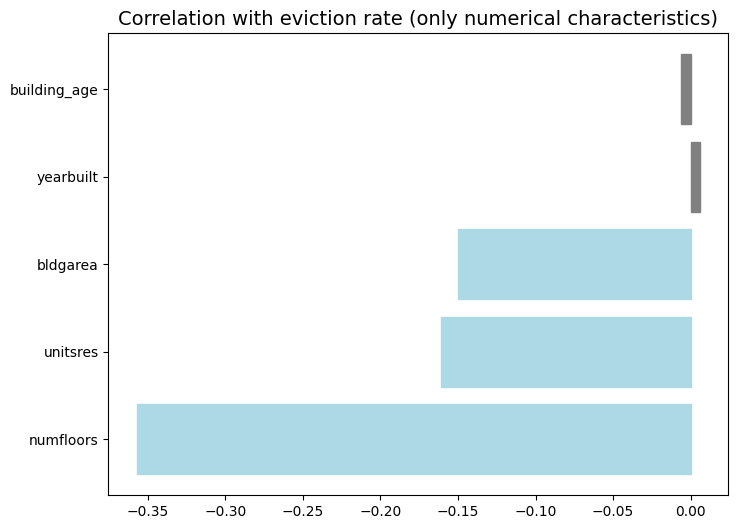

In [36]:
plt.figure(figsize=(8, 6))
bars = plt.barh(corr_data['characteristic'], corr_data['correlation'])
for i, bar in enumerate(bars):
    if corr_data.iloc[i]['significant']:
        if corr_data.iloc[i]['correlation'] > 0:
            bar.set_color('red')
        else:
            bar.set_color('lightblue')
    else:
        bar.set_color('gray')
plt.title('Correlation with eviction rate (only numerical characteristics)', fontsize=14)


very similar resulst from the normal times.

## Categorical analysis:

## 1. Building category (building type)

In [37]:
building_evictions.building_category.unique()
# type of the building, two-family, elevator, etc.....

array(['elevator', None, 'walk-up', 'condo-co-op',
       'primarily_res_with_mixed_use', 'single-family', 'two-family'],
      dtype=object)

### total count per type of buildings over the years

In [38]:
# display(evictions.head())

In [39]:
building_evictions_clean.columns

Index(['bbl_clean', 'average_year_eviction_count', 'eviction_count',
       'unitsres', 'building_category', 'building_type', 'is_llc', 'yearbuilt',
       'bldgclass', 'numfloors', 'bldgarea', 'is_condo', 'floor_category',
       'rent_era', 'architectural_style', 'economic_period',
       'residential_units_category', 'building_size_category', 'size_quartile',
       'eviction_rate_per_unit', 'building_age'],
      dtype='object')

In [49]:
def build_category_dataframes(bbl_cleaned, cleaned_dataframe, category_column, num_years=5):
    category_data = cleaned_dataframe.groupby(category_column).agg(
        total_evictions=('eviction_count', 'count')
    ).reset_index()
    total_evictions = category_data['total_evictions'].sum()
    category_data['eviction_percentage'] = category_data['total_evictions'] / total_evictions
    total_building_count = 753110

    building_counts = bbl_cleaned['bbl'].groupby(bbl_cleaned[category_column]).nunique()
    building_counts_df = bbl_cleaned.groupby(category_column)['bbl'].nunique().reset_index()
    building_counts_df.columns = [category_column, 'building_count']
    total_buildings = building_counts_df.building_count.sum()
    building_counts_df['building_percentage'] = (building_counts_df['building_count'] / total_buildings) * 100

    category_data = pd.merge(category_data, building_counts_df, on=category_column)

    category_data['evictions_per_building'] = category_data['total_evictions'] / category_data['building_count']
    num_years = 3  # during covid
    category_data['yearly_evictions_per_cat'] = category_data['total_evictions'] / num_years
    category_data['yearly_evictions_per_building_per_cat'] = category_data['evictions_per_building'] / num_years

    return category_data

In [44]:
category_data = build_category_dataframes(bbl_cleaned, building_evictions_clean, 'building_category')
category_data

,building_category,total_evictions,eviction_percentage,building_count,building_percentage,evictions_per_building,yearly_evictions_per_cat,yearly_evictions_per_building_per_cat
0,condo-co-op,286,0.060173,11814,1.568695,0.024209,57.2,0.004842
1,elevator,1382,0.290764,10884,1.445207,0.126975,276.4,0.025395
2,primarily_res_with_mixed_use,172,0.036188,33400,4.434943,0.005150,34.4,0.001030
3,single-family,246,0.051757,314302,41.733877,0.000783,49.2,0.000157
4,two-family,745,0.156743,250717,33.290887,0.002971,149.0,0.000594
5,walk-up,1922,0.404376,131993,17.526391,0.014561,384.4,0.002912


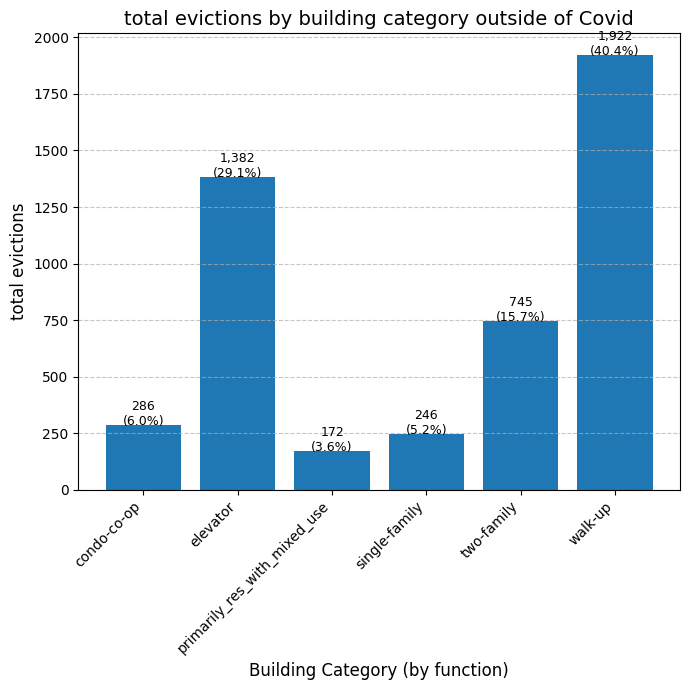

In [45]:
total_all_evictions = category_data['total_evictions'].sum()
# category_data['percentage'] = (category_data['total_evictions'] / total_all_evictions) * 100

plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['building_category'], category_data['total_evictions'])
for i, (value, percentage) in enumerate(zip(category_data['total_evictions'],
                                           category_data['eviction_percentage']*100)):
    plt.text(i, value + (value * 0.0005),
             f"{value:,.0f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Building Category (by function)', fontsize=12)
plt.ylabel('total evictions', fontsize=12)
plt.title('total evictions by building category during Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

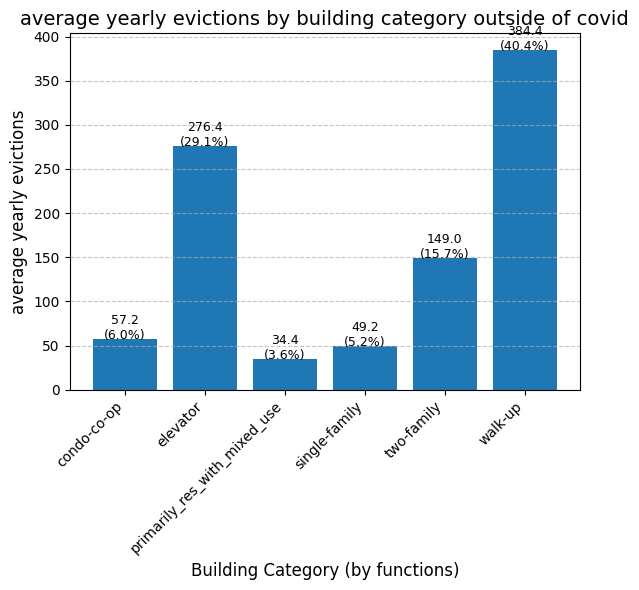

In [46]:
category_data['yearly_evictions'] = category_data['total_evictions'] / 5
total_yearly_evictions = category_data['yearly_evictions'].sum()
category_data['percentage'] = (category_data['yearly_evictions_per_cat'] / total_yearly_evictions) * 100

plt.figure(figsize=(6, 6))
bars = plt.bar(category_data['building_category'], category_data['yearly_evictions_per_cat'])
for i, (value, percentage) in enumerate(zip(category_data['yearly_evictions_per_cat'],
                                            category_data['percentage'])):
    plt.text(i, value + (value * 0.00005),
             f"{value:,.1f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Building Category (by functions)', fontsize=12)
plt.ylabel('average yearly evictions', fontsize=12)
plt.title('average yearly evictions by building category during covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

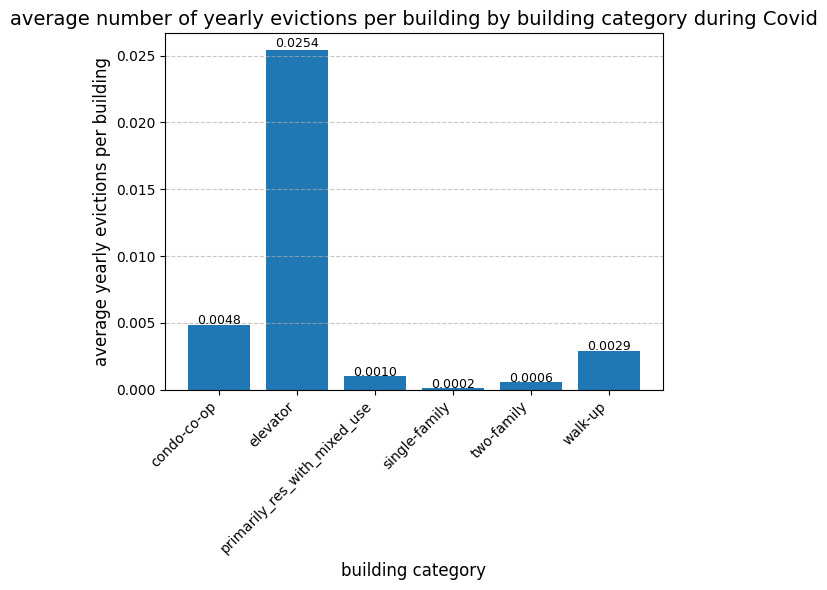

In [50]:
plt.figure(figsize=(6, 6))
bars = plt.bar(category_data['building_category'], category_data['yearly_evictions_per_building_per_cat'])
for i, value in enumerate(category_data['yearly_evictions_per_building_per_cat']):
    plt.text(i, value + (value * 0.01),
             f"{value:.4f}",
             ha='center', fontsize=9)

plt.xlabel('building category', fontsize=12)
plt.ylabel('average yearly evictions per building', fontsize=12)
plt.title('average number of yearly evictions per building by building category during Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

In [48]:
print("ranked list of yearly evictions per building:")
sorted_data = category_data.sort_values('yearly_evictions_per_building_per_cat', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['building_category']
    rate = sorted_data.iloc[i]['yearly_evictions_per_building_per_cat']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. elevator: 0.0254
2. condo-co-op: 0.0048
3. walk-up: 0.0029
4. primarily_res_with_mixed_use: 0.0010
5. two-family: 0.0006
6. single-family: 0.0002


The patterns appear to be very similar to normal times.